In [1]:
from collections import defaultdict
from tqdm import tqdm
import itertools
from joblib import Parallel, delayed, dump, load

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

In [2]:
def process_image_arr_sklearn(images):
    return images.reshape(len(images), -1)
def roc(model, X, y):
    y_score = model.predict_proba(X)[:, 1]
    return roc_auc_score(y, y_score)

In [3]:
breast = np.load("/content/breastmnist.npz")

breast_trainX = process_image_arr_sklearn(breast["train_images"])
breast_trainY = breast["train_labels"].flatten()

breast_valX = process_image_arr_sklearn(breast["val_images"])
breast_valY = breast["val_labels"].flatten()

breast_testX = process_image_arr_sklearn(breast["test_images"])
breast_testY = breast["test_labels"].flatten()

# Models


*   Naive Bayes
*   Decision Trees
*   KNN
*   Logistic Regression
*   Support Vector Machine









In [4]:
models = defaultdict(lambda: {"breast": None})

# Naive Bayes

**Model Accuracy**

In [6]:
from sklearn.naive_bayes import GaussianNB

models["naive_bayes"]["breast"] = GaussianNB()
models["naive_bayes"]["breast"].fit(breast_trainX, breast_trainY)
print(f'breast train acc: {models["naive_bayes"]["breast"].score(breast_trainX, breast_trainY)}')
print(f'breast test acc: {models["naive_bayes"]["breast"].score(breast_testX, breast_testY)}')
print(f'breast val acc: {models["naive_bayes"]["breast"].score(breast_valX, breast_valY)}')

breast train acc: 0.5970695970695971
breast test acc: 0.6025641025641025
breast val acc: 0.5641025641025641


# Decision Trees

In [7]:
from sklearn.tree import DecisionTreeClassifier

#### Hyperparameters to Optimize

- `criterion` {"gini", "entropy", "log_loss"}
- `min_samples_split` - Number of samples that warrant a leaf splitting (indirectly controls `max_depth`)
- `min_samples_leaf` - Number of samples required to be a leaf node?

In [8]:
def eval_params(criterion, min_samples_split, min_samples_leaf):
    model = DecisionTreeClassifier(criterion="log_loss", min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
    return cross_val_score(model, breast_trainX, breast_trainY, scoring="roc_auc", cv=5, n_jobs=-1).mean()

params = itertools.product(
    ("gini", "entropy", "log_loss"),
    range(2, 50),
    range(1, 20)
)

results = Parallel(n_jobs=-1, verbose=10)(delayed(eval_params)(criterion, min_samples_split, min_samples_leaf) for criterion, min_samples_split, min_samples_leaf in params)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   41.6s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   50.4s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   58.8s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  1

In [9]:
params = list(itertools.product(
    ("gini", "entropy", "log_loss"),
    range(2, 50),
    range(1, 20)
))

best_score_index = results.index(max(results))
best_score = results[best_score_index]
best_params = params[best_score_index]

print(f"Params: {best_params}")
print(f"Score: {best_score}")

Params: ('gini', 2, 11)
Score: 0.72265042557835


**Model Accuracy**

In [12]:
models["decision_tree"]["breast"] = DecisionTreeClassifier(criterion="gini", min_samples_split=3, min_samples_leaf=10)
models["decision_tree"]["breast"].fit(breast_trainX, breast_trainY)

print(f'breast train acc: {roc(models["decision_tree"]["breast"], breast_trainX, breast_trainY)}')
print(f'breast test acc: {roc(models["decision_tree"]["breast"], breast_testX, breast_testY)}')
print(f'breast val acc: {roc(models["decision_tree"]["breast"], breast_valX, breast_valY)}')

breast train acc: 0.9705385913764002
breast test acc: 0.7814327485380117
breast val acc: 0.7568922305764411


# K-Nearest Neighbors

In [13]:
from sklearn.neighbors import KNeighborsClassifier

#### Hyperparameters to Optimize

- `n_neighbors` - `k` value
- `weights` {`uniform`, `distance`} - How to weight neighboring points in selection
- `metric` {`braycurtis` , `canberra`, `chebyshev`, `cityblock`, `correlation`, `cosine`, `euclidean`, `jensenshannon`, `mahalanobis`, `minkowski`, `seuclidean`, `sqeuclidean`}

In [24]:
params = itertools.product(
    range(1, int(len(breast_trainX)**0.5)),
    ("uniform", "distance"),
    ('manhattan', 'hamming', 'canberra',  'cosine', 'dice', 'yule', 'correlation', 'l2', 'minkowski', 'jaccard', 'braycurtis', 'sokalsneath', 'euclidean', 'russellrao', 'nan_euclidean', 'cityblock', 'sokalmichener', 'l1', 'rogerstanimoto', 'chebyshev') # Removed 'kulsinski' and 'matching' as they are not valid metrics
)
params = list(params)

def eval_params(n_neighbors, weights, metric):
    model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metric)
    return cross_val_score(model, breast_trainX, breast_trainY, scoring="roc_auc", cv=5, n_jobs=-1).mean()

results = Parallel(n_jobs=-1, verbose=10)(delayed(eval_params)(n_neighbors, weights, metric) for n_neighbors, weights, metric in params)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   

In [25]:
best_score_index = results.index(max(results))
best_score = results[best_score_index]
best_params = params[best_score_index]

print(f"Params: {best_params}")
print(f"Score: {best_score}")

Params: (20, 'distance', 'correlation')
Score: 0.8452934308162374


**Model Accuracy**

In [26]:
models["knn"]["breast"] = KNeighborsClassifier(n_neighbors=1, weights="distance", metric="correlation")
models["knn"]["breast"].fit(breast_trainX, breast_trainY)

print(f'breast train acc: {roc(models["knn"]["breast"], breast_trainX, breast_trainY)}')
print(f'breast test acc: {roc(models["knn"]["breast"], breast_testX, breast_testY)}')
print(f'breast val acc: {roc(models["knn"]["breast"], breast_valX, breast_valY)}')


breast train acc: 1.0
breast test acc: 0.8107769423558897
breast val acc: 0.8972431077694235


# Logistic Regression

#### Hyperparameters to Optimize

- `penalty` - {`None`, `l2`, `l1`, `elasticnet`}
- `C` - Inverse of regularization strength
- `class_weight` - {`balanced`, `None`}

In [28]:
from sklearn.linear_model import LogisticRegression

params = itertools.product(
    (
        (None, "lbfgs"),
        ("l2", "lbfgs"),
        ("l1", "liblinear")
    ),
    range(-6, 6),
    ("balanced", None)
)
params = list(params)

def eval_params(penalty, C, class_weight):
    penalty, solver = penalty
    model = LogisticRegression(penalty=penalty, solver=solver, C=10**C, class_weight=class_weight)
    return cross_val_score(model, breast_trainX, breast_trainY, scoring="roc_auc", cv=5, n_jobs=-1).mean()

results = Parallel(n_jobs=-1, verbose=10)(delayed(eval_params)(penalty, C, class_weight) for penalty, C, class_weight in params)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   45.1s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   52.5s finished


In [29]:
best_score_index = results.index(max(results))
best_score = results[best_score_index]
best_params = params[best_score_index]

print(f"Params: {best_params}")
print(f"Score: {best_score}")

Params: (('l1', 'liblinear'), 4, None)
Score: 0.7923182016586644


**Model Accuracy**

In [30]:
models["logistic"]["breast"] = LogisticRegression(penalty="l1", solver="liblinear", C=10**5, class_weight=None)
models["logistic"]["breast"].fit(breast_trainX, breast_trainY)

print(f'breast train acc: {roc(models["logistic"]["breast"], breast_trainX, breast_trainY)}')
print(f'breast test acc: {roc(models["logistic"]["breast"], breast_testX, breast_testY)}')
print(f'breast val acc: {roc(models["logistic"]["breast"], breast_valX, breast_valY)}')

breast train acc: 1.0
breast test acc: 0.8009607351712613
breast val acc: 0.8512949039264829


# Support Vector Machines

#### Hyperparamters to Optimize

- `C` - regularization param
- `kernel` - {`poly`, `rbf`, `sigmoid`}
- `degree` (for `poly`) and `gamma` (for `rbf` and `poly` and `sigmoid`)

In [31]:
from sklearn.svm import SVC

# for poly
params = itertools.product(
    range(-6, 6),
    range(1, 8),
    ("scale", "auto")
)
params = list(params)

def eval_params(C, degree, gamma):
    model = SVC(C=10**C, kernel="poly", degree=degree, gamma=gamma, probability=True)
    return cross_val_score(model, breast_trainX, breast_trainY, scoring="roc_auc", cv=5, n_jobs=-1).mean()

results = Parallel(n_jobs=-1, verbose=10)(delayed(eval_params)(C, kernel, degree) for C, kernel, degree in params)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   49.8s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  2

In [32]:
best_score_index = results.index(max(results))
best_score = results[best_score_index]
best_params = params[best_score_index]

print(f"Params: {best_params}")
print(f"Score: {best_score}")

Params: (-5, 2, 'auto')
Score: 0.7881460788593045


In [33]:
#Other Kernels

# for poly
params = itertools.product(
    range(-6, 6),
    ("linear", "rbf", "sigmoid"),
    ("scale", "auto")
)
params = list(params)

def eval_params(C, kernel, gamma):
    model = SVC(C=10**C, kernel=kernel, gamma=gamma, probability=True)
    return cross_val_score(model, breast_trainX, breast_trainY, scoring="roc_auc", cv=5, n_jobs=-1).mean()

results = Parallel(n_jobs=-1, verbose=10)(delayed(eval_params)(C, kernel, degree) for C, kernel, degree in params)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   52.5s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  1.6min finished


In [34]:
best_score_index = results.index(max(results))
best_score = results[best_score_index]
best_params = params[best_score_index]

print(f"Params: {best_params}")
print(f"Score: {best_score}")

Params: (1, 'rbf', 'scale')
Score: 0.818351956932926


**Model Accuracy**

In [36]:
models["svc"]["breast"] = SVC(C=10, kernel="rbf", gamma="scale", probability=True)
models["svc"]["breast"].fit(breast_trainX, breast_trainY)

print(f'breast train acc: {roc(models["svc"]["breast"], breast_trainX, breast_trainY)}')
print(f'breast test acc: {roc(models["svc"]["breast"], breast_testX, breast_testY)}')
print(f'breast val acc: {roc(models["svc"]["breast"], breast_valX, breast_valY)}')

breast train acc: 0.9998465551634187
breast test acc: 0.8592314118629908
breast val acc: 0.9390142021720969


In [37]:
dump(dict(models), "sklearn_models.joblib")

['sklearn_models.joblib']

In [38]:
models = load("sklearn_models.joblib")

# Analyzing Performance

Text(0.5, 1.0, 'ROC of Different Models for Breast MNIST')

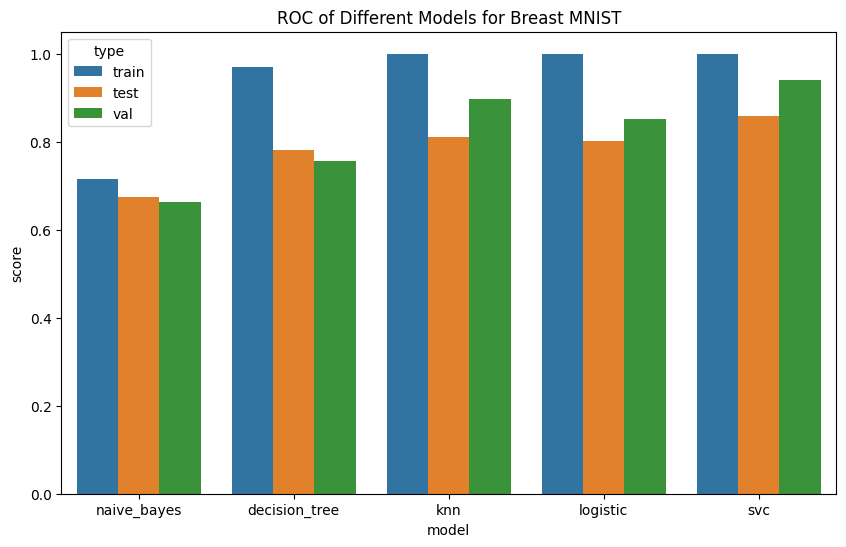

In [39]:
data = []

for model in models:
    for dataset_type in ("train", "test", "val"):
        data.append((
            model,
            dataset_type,
            roc(models[model]["breast"], eval(f"breast_{dataset_type}X"), eval(f"breast_{dataset_type}Y"))
        ))

data = pd.DataFrame(data, columns=["model", "type", "score"])

plt.figure(figsize=(10, 6))
sns.barplot(data=data, x="model", y="score", hue="type") \
    .set_title("ROC of Different Models for Breast MNIST")


# Ensemble Learning

In [53]:
import numpy as np
from sklearn.metrics import roc_auc_score
from joblib import load

In [54]:
def process_image_arr_sklearn(images):
    return images.reshape(len(images), -1)

def roc(model, X, y):
    y_score = model.predict_proba(X)[:, 1]
    return roc_auc_score(y, y_score)

In [40]:
sklearn_models = load("/content/sklearn_models.joblib")

In [ ]:
!pip install libauc

In [49]:
import torch
from torchvision import transforms

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

In [50]:
resnet_breast = torch.load("/content/resnet_breast.pt", map_location=torch.device('cpu'))

In [51]:
resnet_breast.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [55]:
# REFORMATING THE DATA

breast = np.load("/content/breastmnist.npz")

breast_trainX = breast["train_images"]
breast_trainY = breast["train_labels"].flatten()

breast_valX = breast["val_images"]
breast_valY = breast["val_labels"].flatten()

breast_testX = breast["test_images"]
breast_testY = breast["test_labels"].flatten()

breast_trainX_sk = process_image_arr_sklearn(breast["train_images"])
breast_trainY_sk = breast["train_labels"].flatten()

breast_valX_sk = process_image_arr_sklearn(breast["val_images"])
breast_valY_sk = breast["val_labels"].flatten()

breast_testX_sk = process_image_arr_sklearn(breast["test_images"])
breast_testY_sk = breast["test_labels"].flatten()

In [56]:
input_tensor = data_transform(breast_trainX[0])
input_batch = input_tensor.unsqueeze(0)

with torch.no_grad():
    output = torch.sigmoid(resnet_breast(input_batch))
print(output)

tensor([[0.9863]])


In [57]:
sklearn_models

{'naive_bayes': {'breast': GaussianNB()},
 'decision_tree': {'breast': DecisionTreeClassifier(min_samples_leaf=10, min_samples_split=3),
  'pneumonia': DecisionTreeClassifier(min_samples_leaf=10, min_samples_split=3)},
 'knn': {'breast': KNeighborsClassifier(metric='correlation', n_neighbors=1, weights='distance')},
 'logistic': {'breast': LogisticRegression(C=100000, penalty='l1', solver='liblinear')},
 'svc': {'breast': SVC(C=10, probability=True)}}

In [58]:
probs = []
for idx in range(len(breast_testX)):
    prob = []
    for model in sklearn_models:
        prob.append(sklearn_models[model]["breast"].predict_proba(np.array([breast_testX_sk[idx]]))[:, 1][0])

    input_tensor = data_transform(breast_trainX[0]).unsqueeze(0)

    with torch.no_grad():
        output = torch.sigmoid(resnet_breast(input_tensor))
    prob.append(float(output[0][0]))

    probs.append(sum(prob)/len(prob))

In [59]:
roc_auc_score(breast_testY_sk, probs)

0.880952380952381